In [4]:
# 测试上涨下跌家数与股市关系
import pymongo
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import datetime
import copy
import pandas as pd
import sys
from operator import itemgetter
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d

np.set_printoptions(formatter={'float_kind': "{:.6f}".format})
client = pymongo.MongoClient('localhost', 27017)
db = client.quanLiang

In [6]:
with open(r"d:\pkl\dailyBarMtx.pkl",'rb+') as f:
    z = pickle.load(f)
dtes = z['dtes']
dtes = np.array(dtes).astype(np.int)
tkrs = list(z['tkrs'])
open_mtx = z['open_mtx']
high_mtx = z['high_mtx']
low_mtx = z['low_mtx']
close_mtx = z['close_mtx']
name = z['name']
belong = z['belong']
shenwan1 = z['shenwan1']
shenwan2 = z['shenwan2']
shenwan3 = z['shenwan3']
return_mtx = close_mtx[:,1:] / close_mtx[:,:-1] - 1
m = np.zeros((len(tkrs),1))
return_mtx = np.concatenate((m, return_mtx),axis=1)
return_mtx[np.isfinite(return_mtx)==False] = 0
return_mtx_intraday = close_mtx / open_mtx - 1
return_mtx_intraday[np.isfinite(return_mtx_intraday)==False] = 0


C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [7]:
def getPerformanceByDates(targetDates, option={}):
    #计算上涨比例
    q = np.array([list(dtes).index(k) for k in targetDates])
    probSh000001B0byIntraday = return_mtx_intraday[list(tkrs).index('SH000001'), q]>0  # 上证指数日内涨幅大于0的概率
    probSh000001B0byC2C = return_mtx[list(tkrs).index('SH000001'), q]>0 # 上证指数收盘较前收盘大于0的概率
    idxD = [list(dtes).index(k) for k in targetDates]
    idxA = np.nonzero(belong=='A股')[0]
    upNums = np.sum(return_mtx[idxA][:,idxD]>0,axis=0)
    downNums = np.sum(return_mtx[idxA][:,idxD]<0,axis=0)
    totNums = np.sum(return_mtx[idxA][:,idxD]!=0,axis=0)
    upNumsIntraday = np.sum(return_mtx_intraday[idxA][:,idxD]>0,axis=0)
    downNumsIntraday = np.sum(return_mtx_intraday[idxA][:,idxD]<0,axis=0)
    totNumsIntraday = np.sum(return_mtx_intraday[idxA][:,idxD]!=0,axis=0)
    #plt.plot(downNums)
    #plt.plot(totNums)
    propShangZhang = (totNums-downNums)/totNums
    returnShangZhengAvg = np.sum(np.atleast_2d(return_mtx_intraday[(tkrs).index('SH000001')])[:, idxD])/len(idxD)
    #plt.plot(propShangZhang)

    # 说明:
    # order1 = idxShenWan1[np.argsort(np.mean(np.argsort(np.atleast_2d(return_mtx[idxShenWan1])[:, idxD],axis=0), axis=1))]
    # 对回报率的每一列进行排序(从小到大)， 然后每一行取一个序号的平均值， 叫做“平均涨幅排名”, 这样排名大的说明平均回报率较好
    
    idxShenWan1 = np.nonzero(belong=='申万一级')[0]
    order1 = idxShenWan1[np.argsort(np.mean(np.argsort(np.atleast_2d(return_mtx[idxShenWan1])[:, idxD],axis=0), axis=1))]
    #order1 = idxShenWan1[np.sum(np.argsort(return_mtx[idxShenWan1], axis=0), axis=1)]
    idxShenWan2 = np.nonzero(belong=='申万二级')[0]
    order2 = idxShenWan2[np.argsort(np.mean(np.argsort(np.atleast_2d(return_mtx[idxShenWan2])[:, idxD], axis=0), axis=1))]
    #order2 = idxShenWan2[np.argsort(np.sum(return_mtx[idxShenWan1][:,idxD], axis=1))]
    idxShenWan3 = np.nonzero(belong=='申万三级')[0]
    order3 = idxShenWan3[np.argsort(np.mean(np.argsort(np.atleast_2d(return_mtx[idxShenWan3])[:, idxD], axis=0), axis=1))]
    #order3 = idxShenWan3[np.argsort(np.sum(return_mtx[idxShenWan1][:,idxD], axis=1))]
    orderA = idxA[np.argsort(np.mean(np.argsort(np.atleast_2d(return_mtx[idxA])[:, idxD], axis=0), axis=1))]
    #orderA = idxA[np.argsort(np.sum(return_mtx[idxA],axis=1))]

    idxShenWan1Intraday = np.nonzero(belong=='申万一级')[0]
    order1Intraday = idxShenWan1Intraday[np.argsort(np.mean(np.argsort(np.atleast_2d(return_mtx[idxShenWan1Intraday])[:, idxD], axis=0), axis=1))]
    #order1Intraday = idxShenWan1Intraday[np.argsort(np.sum(return_mtx_intraday[idxShenWan1Intraday][:,idxD],axis=1))]
    idxShenWan2Intraday = np.nonzero(belong=='申万二级')[0]
    order2Intraday = idxShenWan2Intraday[np.argsort(np.mean(np.argsort(np.atleast_2d(return_mtx[idxShenWan2Intraday])[:, idxD], axis=0), axis=1))]
    #order2Intraday = idxShenWan2Intraday[np.argsort(np.sum(return_mtx_intraday[idxShenWan1Intraday][:,idxD],axis=1))]
    idxShenWan3Intraday = np.nonzero(belong=='申万三级')[0]
    order3Intraday = idxShenWan3Intraday[np.argsort(np.mean(np.argsort(np.atleast_2d(return_mtx[idxShenWan3Intraday])[:, idxD], axis=0), axis=1))]
    #order3Intraday = idxShenWan3Intraday[np.argsort(np.sum(return_mtx_intraday[idxShenWan1Intraday][:,idxD],axis=1))]
    idxAIntraday = np.nonzero(belong=='A股')[0]
    orderAIntraday = idxAIntraday[np.argsort(np.mean(np.argsort(np.atleast_2d(return_mtx[idxAIntraday])[:, idxD], axis=0), axis=1))]
    #orderAIntraday = idxAIntraday[np.argsort(np.sum(return_mtx_intraday[idxA], axis=1))]

    bestShenWan1 = name[order1[-1:-6:-1]]
    bestShenWan1_return = np.sum(return_mtx, axis=1)[order1[-1:-6:-1]]
    bestShenWan2 = name[order2[-1:-11:-1]]
    bestShenWan2_return = np.sum(return_mtx, axis=1)[order2[-1:-11:-1]]
    bestShenWan3 = name[order3[-1:-16:-1]]
    bestShenWan3_return = np.sum(return_mtx, axis=1)[order3[-1:-16:-1]]
    bestA = name[orderA[-1:-21:-1]]
    bestA_return = return_mtx[orderA[-1:-21:-1]]

    d = name[order1Intraday[-1:-6:-1]]
    bestShenWan1_returnIntraday = np.sum(return_mtx, axis=1)[order1Intraday[-1:-6:-1]]
    bestShenWan2Intraday = name[order2Intraday[-1:-11:-1]]
    bestShenWan2_returnIntraday = np.sum(return_mtx, axis=1)[order2Intraday[-1:-11:-1]]
    bestShenWan3Intraday = name[order3Intraday[-1:-16:-1]]
    bestShenWan3_returnIntraday = np.sum(return_mtx, axis=1)[order3Intraday[-1:-16:-1]]
    bestAIntraday = name[orderAIntraday[-1:-21:-1]]
    bestA_returnIntraday = return_mtx[orderAIntraday[-1:-21:-1]]

    if ('printOut' in option):
        print('平均股票上涨概率', np.mean(propShangZhang))
        print('上证平均日回报率', returnShangZhengAvg)
        print('表现最好的申万一级行业:',  bestShenWan1Intraday)
        print('表现最好的申万二级行业:',  bestShenWan2Intraday)
        print('表现最好的申万三级行业:',  bestShenWan3Intraday)
        print('表现最好的个股:',  bestA)
        print('检验日期:', targetDates)
        print('上涨股票数量：'+str(upNums), ' 下跌股票数量：'+str(downNums))
        print('上涨概率变化', propShangZhang)
    if ('draw' in option):
        plt.rcParams['font.sans-serif'] = [u'SimHei']
        plt.rcParams['axes.unicode_minus'] = False
        default_dpi = plt.rcParamsDefault['figure.dpi']
        plt.rcParams['figure.dpi'] = default_dpi*1
        plt.figure()
        plt.title(option['title'])
        plt.ylabel('上涨的股票数')
        plt.plot(upNums)
        plt.figure()
        plt.title('上证指数日内涨幅>0概率='+str(np.round(1e4*np.mean(probSh000001B0byIntraday))/1e2)
                  +'%  (cumsum/#) \n较前收涨幅>0概率='+str(np.round(1e4*np.mean(probSh000001B0byC2C))/1e2)+'%')
        plt.plot(np.cumsum(probSh000001B0byIntraday-0.5)/range(1,len(probSh000001B0byIntraday)+1))
        plt.xlabel('符合条件日期的样本')
        #plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=None, hspace=0.5)
    return [probSh000001B0byIntraday, probSh000001B0byC2C, upNums, downNums, upNumsIntraday, downNumsIntraday, bestShenWan1,  bestShenWan2,  bestShenWan3, bestShenWan1Intraday, bestShenWan2Intraday, bestShenWan3Intraday]

In [710]:
idxA = (belong=='A股')
upNums = np.sum(return_mtx[idxA, :]>0, axis=0)
downNums = np.sum(return_mtx[idxA,:]<0,axis=0)
totNums =  np.sum(return_mtx[idxA,:]!=0,axis=0)
propShangZhang = (totNums-downNums)/totNums


C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [102]:
#0.创业板涨幅超过3%或者4%后第二天市场表现：
testName = '创业板涨幅超过3%或者4%后第二天市场表现'
q = db.tkrsInfo.find_one({'ticker':'SZ399006'})
close = np.array([m[2] for m in q['dailyBar']])
v = close[close!=0]
r = v[1:]/v[:-1]-1
idx = np.nonzero(r>0.03)[0]
rnext = r[idx+1]+r[idx+2]+r[idx+3]+r[idx+4]+r[idx+5]
print(rnext)
np.mean(rnext)
print(np.mean(rnext))
print(np.sum(rnext>0)/np.sum(rnext!=0))
print(np.sum(rnext>0))
#idx = tkrs.index('SZ399006')
#idx = np.array([int(x>tn) for x in upNums])
#q = np.nonzero(idx == 1)[0]
#targetDates = dtes[q+1]
#targetDates = targetDates[targetDates>20150101]
#[probSh000001B0byIntraday, probSh000001B0byC2C, ups, downs, upsIntraday, downsIntraday, bestShenWan1,  bestShenWan2,  bestShenWan3, bestShenWan1Intraday, bestShenWan2Intraday, bestShenWan3Intraday] = getPerformanceByDates(targetDates, {'draw':1, 'title':testName})
print(len(rnext))
print(np.quantile(rnext, 0.9))
print(np.quantile(rnext, 0.1))


[0.077265 0.063394 -0.115452 -0.120669 0.029261 -0.050067 0.050213
 0.017484 0.042785 0.035852 0.044238 0.005249 0.031152 0.045080 0.041712
 -0.030994 -0.053817 0.088920 0.001890 -0.076699 -0.043434 -0.098165
 0.000000 0.034159 -0.004167 -0.012143 -0.020145 0.019107 0.007462
 -0.079518 -0.034419 0.065536 -0.023723 -0.039486 -0.103733 0.080776
 0.063311 -0.027835 0.028016 -0.056293 -0.028469 0.052319 0.032515
 0.029280 -0.006424 0.028611 -0.099456 -0.010235 0.025793 -0.006850
 -0.064574 -0.001304 -0.024067 0.044189 0.040444 0.015396 -0.003310
 0.057759 0.062420 0.001555 -0.029010 -0.000188 -0.052859 0.025239
 0.005334 0.062808 0.024063 0.060170 0.061439 0.021682 -0.030039 0.004573
 -0.084088 -0.170421 -0.170610 0.073824 0.077760 0.030592 0.085737
 -0.032066 0.057529 0.063552 0.009367 -0.070039 -0.122422 -0.297462
 -0.048340 0.019683 -0.105254 0.082207 0.018073 0.100202 0.072193 0.026682
 -0.008484 0.076678 0.004782 -0.044756 0.023345 0.015779 0.033941
 -0.007015 -0.072658 0.028899 0.015

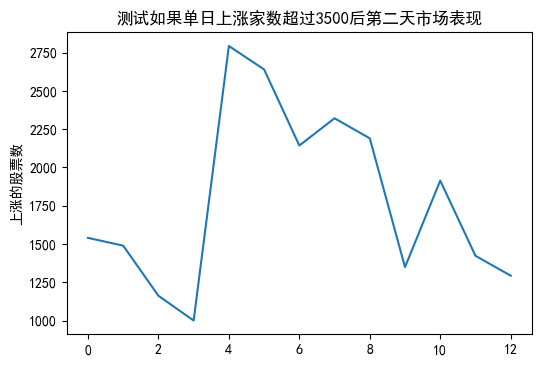

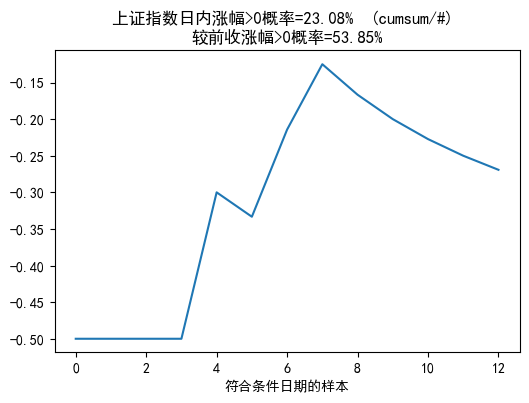

In [711]:
#1.测试如果连续两日上涨家数超过3500只，次日大盘平均回报率，胜率，样本数：
testName = '测试如果连续两日上涨家数超过3500后第二天市场表现'
testName = '测试如果单日上涨家数超过3500后第二天市场表现'
tn = 3500
idx = np.array([int(x>tn) for x in upNums])
q = np.nonzero(idx == 1)[0]
targetDates = dtes[q+1]
targetDates = targetDates[targetDates>20150101]
[probSh000001B0byIntraday, probSh000001B0byC2C, ups, downs, upsIntraday, downsIntraday, bestShenWan1,  bestShenWan2,  bestShenWan3, bestShenWan1Intraday, bestShenWan2Intraday, bestShenWan3Intraday] = getPerformanceByDates(targetDates, {'draw':1, 'title':testName})


In [705]:
#
testName = '测试如果连续两日上涨家数超过3500后第二天上涨股票数目'
tn = 3500
idx = np.array([int(x>tn) for x in upNums])
q = np.nonzero(idx[1:]+idx[:-1] == 2)[0]
targetDates = dtes[q+2]
targetDates = targetDates[targetDates>20150101]
if len(targetDates)==0:
    print('none')
else:
    [probSh000001B0byIntraday, probSh000001B0byC2C, ups, downs, upsIntraday, downsIntraday, bestShenWan1,  bestShenWan2,  bestShenWan3, bestShenWan1Intraday, bestShenWan2Intraday, bestShenWan3Intraday] = getPerformanceByDates(targetDates, {'draw':1, 'title':testName})


none


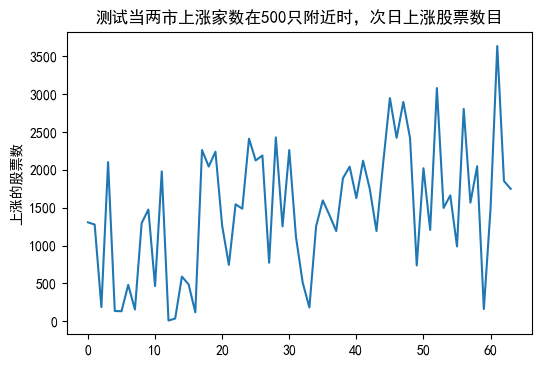

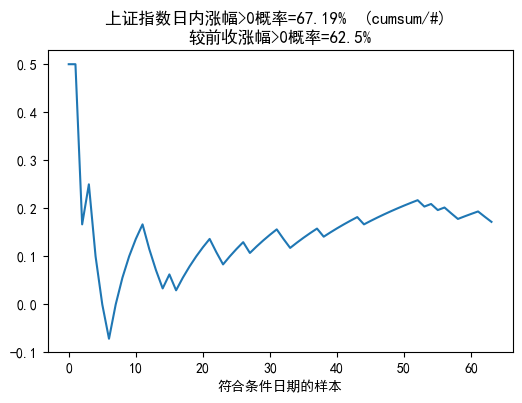

In [712]:
#
testName = '测试当两市上涨家数在500只附近时，次日上涨股票数目'
tn = 300
idx = np.array([int(x<tn) for x in upNums])
q = np.nonzero(idx == 1)[0]
targetDates = dtes[q+1]
targetDates = targetDates[targetDates>20150101]
[probSh000001B0byIntraday, probSh000001B0C2C, ups, downs, upsIntraday, downsIntraday, bestShenWan1,  bestShenWan2,  bestShenWan3, bestShenWan1Intraday, bestShenWan2Intraday, bestShenWan3Intraday] = getPerformanceByDates(targetDates, {'draw':1, 'title':testName})


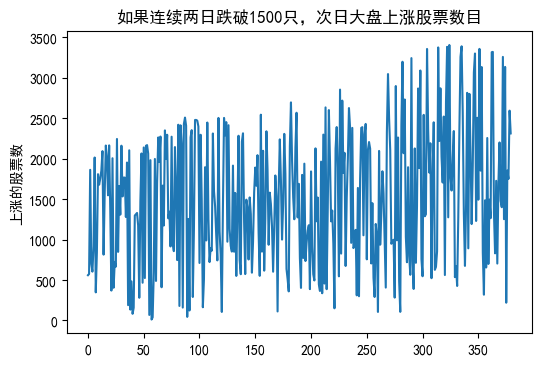

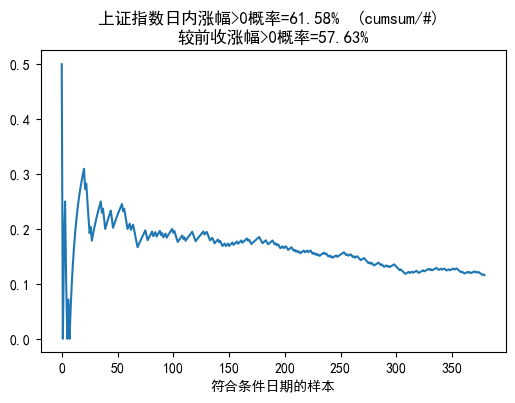

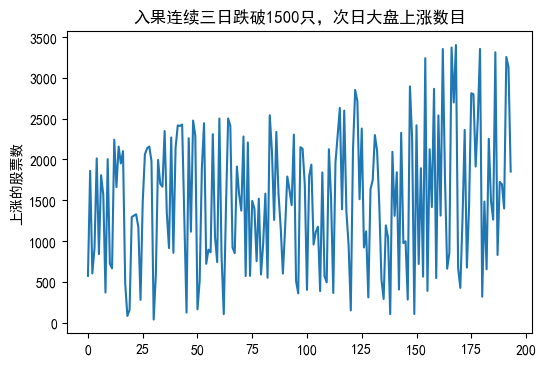

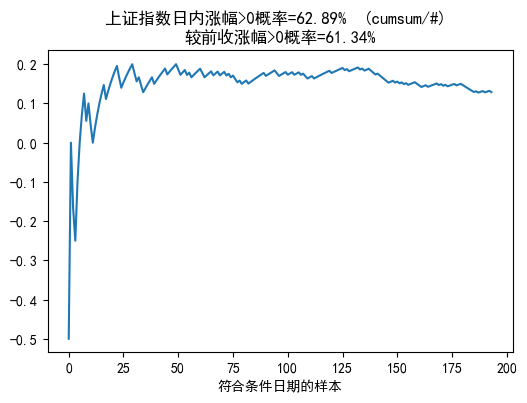

In [707]:
#
testName = '如果连续两日跌破1500只，次日大盘上涨股票数目' 
tn = 1500
idx = np.array([int(x<tn) for x in upNums])
q = np.nonzero(idx[:-1] + idx[1:] == 2)[0]
targetDates = dtes[q+2]
targetDates = targetDates[targetDates>20150101]
[probSh000001B0byIntraday, probSh000001B0C2C, ups, downs, upsIntraday, downsIntraday, bestShenWan1,  bestShenWan2,  bestShenWan3, bestShenWan1Intraday, bestShenWan2Intraday, bestShenWan3Intraday] = getPerformanceByDates(targetDates, {'draw':1, 'title':testName})

#
testName = '入果连续三日跌破1500只，次日大盘上涨数目'
tn = 1500
idx = np.array([int(x<tn) for x in upNums])
q = np.nonzero(idx[:-2] + idx[1:-1] + idx[2:] == 3)[0]
targetDates = np.array(dtes[q+3])
targetDates = targetDates[targetDates>20150101]
[probSh000001B0byIntraday, probSh000001B0C2C, ups, downs, upsIntraday, downsIntraday, bestShenWan1,  bestShenWan2,  bestShenWan3, bestShenWan1Intraday, bestShenWan2Intraday, bestShenWan3Intraday] = getPerformanceByDates(targetDates, {'draw':1, 'title':testName})

